# Tabular Learning
The goal here is to make a table that is able to learn the best actions based on the hour, net_electricity_use and current soc.
To start with, the continuous observations are discretized into 10 buckets, and actions are discretized into 11 buckets (for an explicit 0 action), making a table with $24*10*10*11=26400$ entries.
For now, we're only looking at individual metrics, so excluding grid costs.

In [1]:
# To run this example, move this file to the main directory of this repository
import citylearn.citylearn
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as pyplot

import time
from gym import spaces

from agents.orderenforcingwrapper import OrderEnforcingAgent
from citylearn.citylearn import CityLearnEnv


In [ ]:
# Load the environment model
# We will use this as a simulation to update the state values.

In [2]:
class Constants:
    episodes = 3
    schema_path = './data/citylearn_challenge_2022_phase_1/schema.json'

def action_space_to_dict(aspace):
    """ Only for box space """
    return { "high": aspace.high,
             "low": aspace.low,
             "shape": aspace.shape,
             "dtype": str(aspace.dtype)
    }

def env_reset(env):
    observations = env.reset()
    action_space = env.action_space
    observation_space = env.observation_space
    building_info = env.get_building_information()
    building_info = list(building_info.values())
    action_space_dicts = [action_space_to_dict(asp) for asp in action_space]
    observation_space_dicts = [action_space_to_dict(osp) for osp in observation_space]
    obs_dict = {"action_space": action_space_dicts,
                "observation_space": observation_space_dicts,
                "building_info": building_info,
                "observation": observations }
    return obs_dict

In [3]:
# load environment
env = CityLearnEnv(schema=Constants.schema_path)
obs_dict = env_reset(env)


episodes_completed = 0
num_steps = 0
interrupted = False
episode_metrics = []

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
observations_spaces = obs_dict["observation_space"]
actions_spaces = obs_dict["action_space"]

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = obs_dict["building_info"]

params_agent = {#'building_ids':["Building_"+str(i) for i in [1,2,3,4,5]],
                 'building_info':building_info,
                 'observation_space': spaces.Box(**observations_spaces[0]),
                 'action_space':spaces.Box(**actions_spaces[0])}

# Instantiating the control agent(s)
agents = Agent(**params_agent)

In [5]:
# actually train:
for episode in range(Constants.episodes):
    print("Starting Episode {}/{}:".format(episode, Constants.episodes))
    done = False
    actions = []
    timestep = 0

    states = env.reset()
    for i in range(5):
        actions.append(agents.select_actions(states[i]))
    while not done:
        next_states, reward, done, _ = env.step(actions)
        actions_next = []
        for i in range(5):
            actions_next.append(agents.select_actions(next_states[i]))
            agents.add_to_buffer(states[i], actions[i], reward[i], next_states[i], done)
        states = next_states
        actions = actions_next

        if timestep % 1000 == 0:
            print(timestep, ":", reward)
        timestep += 1
   
    print("evaluation after episode {}".format(episode), env.evaluate())

Starting Episode 0/3:
0 : [-1.77832637e+00 -3.15404106e+00 -3.47740129e-07 -4.92163870e+00
 -1.54341048e+00]
1000 : [-0.         -2.32337695 -0.         -0.         -7.02821815]
2000 : [-0. -0. -0. -0. -0.]
3000 : [-1.2522792  -0.85347936 -0.29929212 -0.7263253  -2.12508933]
4000 : [-3.29106118 -5.12310468 -2.50650823 -2.54929631 -0.07231429]
5000 : [-0.44233557 -0.         -5.75361914 -0.2530861  -0.01917416]
6000 : [-1.05793898 -0.83608354 -1.58072723 -2.29582683 -0.86633763]
7000 : [-10.61070541  -0.          -0.          -0.         -12.05210348]
8000 : [-0.60832294 -0.80436402 -0.         -1.56384297 -2.6520673 ]
evaluation after episode 0 (0.9775594406534965, 1.0471785872647668)
Starting Episode 1/3:
0 : [-1.77832637e+00 -3.15404106e+00 -3.47740129e-07 -4.92163870e+00
 -1.54341048e+00]
1000 : [ -0.          -6.58631469  -0.          -0.         -11.85185954]
2000 : [-0. -0. -0. -0. -0.]
3000 : [-1.2522792  -0.85347936 -0.29929212 -0.7263253  -2.12508933]
4000 : [-3.29106118 -5.12

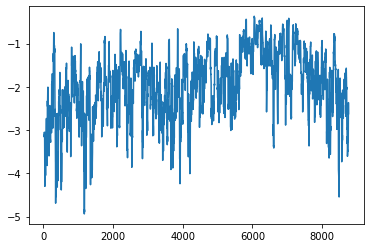

In [6]:
plt.plot(pd.Series([reward[0] for reward in env.rewards[1:]]).rolling(24).mean())

In [7]:
import pickle
with open("agent.pickle", "wb") as f:
    pickle.dump(agents, f)
with open("env.pickle", "wb") as f:
    pickle.dump(env, f)


SoftQNetwork(
  (linear1): Linear(in_features=29, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)
